Fingind scaling factor

In [1]:
import My_functions as Mf
import os
import pickle
from openpiv import tools, scaling, pyprocess, validation, filters,preprocess
import matplotlib.pyplot as plt
import numpy as np

parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output', 'Single')
pic_folder = os.path.join(parent_folder, 'Picture', 'single')
Mf.create_directory(save_folder)

lenghght = Mf.calculate_distance_between_points_napari_notebook_line(Mf.find_pictures(pic_folder)[0], initial_guess = [[337.77, 449.48], [369.14, 449.48]], to_print=True) #pixel

known_lenght = 9.525/1000 #[m]
scaling_factor = lenghght/known_lenght #pixel/m
print('Scaling factor:', scaling_factor)

ModuleNotFoundError: No module named 'My_functions'

# At the beginning I will use only two pictures

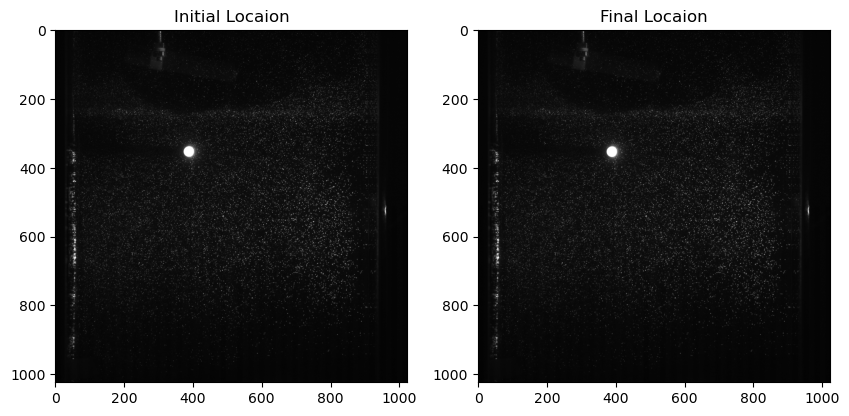

In [2]:
im_a_path = Mf.find_pictures(pic_folder)[0]
im_b_path = Mf.find_pictures(pic_folder)[-1]
im_a  = tools.imread(im_a_path)
im_b  = tools.imread(im_b_path)

fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(im_a, cmap=plt.cm.gray)
ax[1].imshow(im_b, cmap=plt.cm.gray)
ax[0].set_title('Initial Locaion')
ax[1].set_title('Final Locaion')
plt.show()

Choose the area to PIV on

In [3]:
range_cut = Mf.select_area_napari_notebook(pic_folder, stack_photos = True, rectangle_data = [[232, 208], [232, 528], [552, 528], [552, 208]])

rectangle_data = [[232, 208], [232, 528], [552, 528], [552, 208]]


c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\Picture\single\C001H001S0010000210.tif
c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\Picture\single\C001H001S0010000211.tif


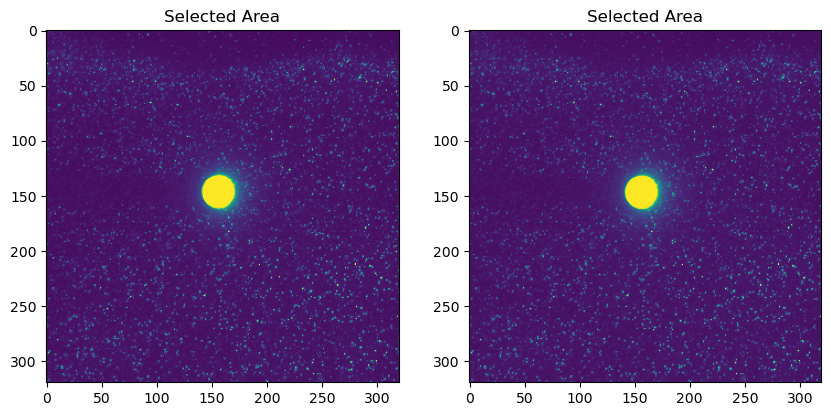

In [4]:
im_a = Mf.read_image(Mf.find_pictures(pic_folder)[0])
im_b = Mf.read_image(Mf.find_pictures(pic_folder)[-1])

print(Mf.find_pictures(pic_folder)[0])
print(Mf.find_pictures(pic_folder)[-1])

frame_a =  im_a[range_cut]
frame_b =  im_b[range_cut]

fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(frame_a)
ax[1].imshow(frame_b)
ax[0].set_title('Selected Area')
ax[1].set_title('Selected Area')
plt.show()

# from PIL import Image
Mf.create_directory(os.path.join(save_folder, 'cut_image'))
Mf.save_image(os.path.join(save_folder,'cut_image', 'cut_image_1.tif'), frame_a)

1.5


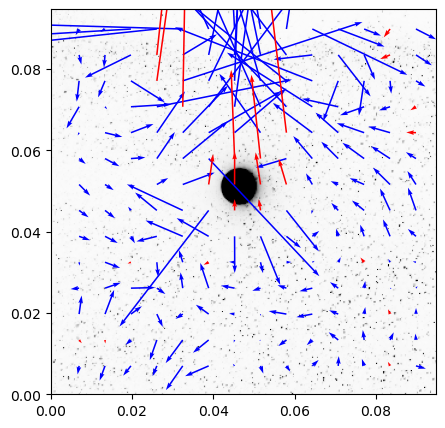

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [12]:
window_size = 42 # pixels
search_area_size = window_size # pixels 
overlap = round(search_area_size/2) # pixels
scale = 0.01/5 # scale defines here the arrow length
width = 0.004 # width is the thickness of the arrow
threshold = 1.5
u_thresholds = 100

frame_rate = 60
dt = 1/frame_rate # sec

display_plot = True # display plot
# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32) ,
                                                    frame_b.astype(np.int32), 
                                                    window_size = window_size,
                                                    overlap = overlap, 
                                                    dt= dt, 
                                                    search_area_size = search_area_size, 
                                                    sig2noise_method = 'peak2peak')
x, y = pyprocess.get_coordinates( image_size = frame_a.shape, search_area_size = search_area_size, overlap = overlap )
flags_g = validation.global_val( u, v, (-u_thresholds, u_thresholds),(-u_thresholds, u_thresholds))
flags_s2n = validation.sig2noise_val( sig2noise, threshold = 1.1)
flags = flags_g | flags_s2n
u, v = filters.replace_outliers( u, v, flags, method='localmean', max_iter = 3, kernel_size = 3)

# FOR SI use scaling factor to get new coordinates
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = scaling_factor) # [m/s] and [m]
x, y, u, v = tools.transform_coordinates(x, y, u, v)

# save to a file
tools.save(os.path.join(save_folder,'test_two_pic_only.txt'), x, y, u, v, flags, None, fmt='%.16e', delimiter='\t')

fig, ax = plt.subplots(figsize=(5,5))
# ax.imshow(masked_b)
print(threshold)
tools.display_vector_field(os.path.join(save_folder,'test_two_pic_only.txt'), ax=ax,
                            scaling_factor = scaling_factor, scale = scale, width = width, on_img=True,
                        image_name =  os.path.join(save_folder, 'cut_image', 'cut_image_1.tif'))

## <span style='color:Red'> Mask </span>

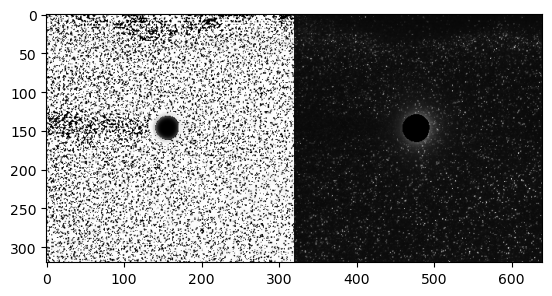

In [ ]:
# masking using not optimal choice of the methods or parameters:
masked_a, _ = preprocess.dynamic_masking(frame_a, method = 'edges', filter_size = 3, threshold = 0.055)
masked_b, _ = preprocess.dynamic_masking(frame_b, method = 'intensity', filter_size = 3)

plt.imshow(np.c_[masked_a,masked_b], cmap='gray')
plt.show()

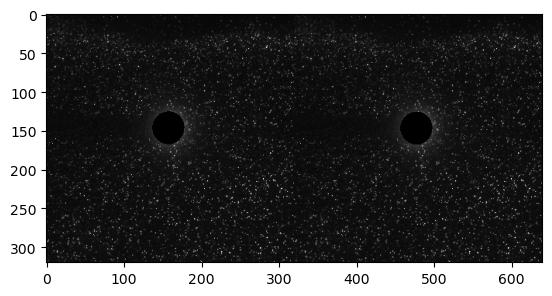

In [ ]:
# masking using optimal (manually tuned) set of parameters and the right method:
masked_a, _ = preprocess.dynamic_masking(frame_a, method='intensity', filter_size=7, threshold=0.01)
masked_b, _ = preprocess.dynamic_masking(frame_b, method='intensity', filter_size=7, threshold=0.01)
plt.imshow(np.c_[masked_a,masked_b], cmap='gray')

In [ ]:
# import tifffile
from PIL import Image
Mf.create_directory(os.path.join(save_folder, 'cut_image'))
Image.fromarray(masked_b).save(os.path.join(save_folder,'cut_image', 'cut_part.tif' ))

In [ ]:

window_size = 32 # pixels
search_area_size = 32 # pixels 
overlap = 16 # pixels
scale = 0.04 # scale defines here the arrow length
width = 0.003 # width is the thickness of the arrow
threshold = 1.1

display_plot = True # display plot

In [ ]:
thresholds = np.arange(0.1,1.4,0.1).tolist()

0.1


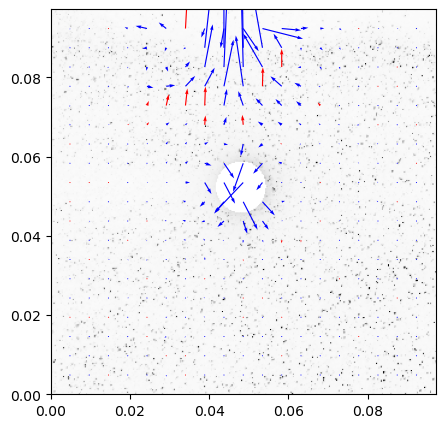

0.2


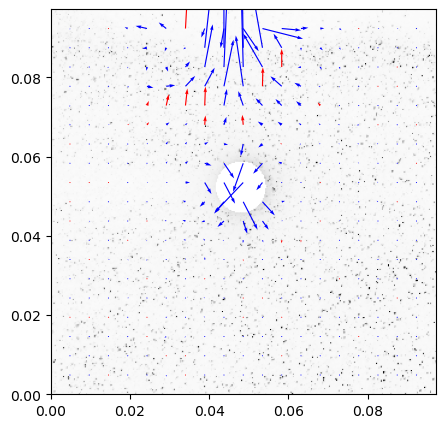

0.30000000000000004


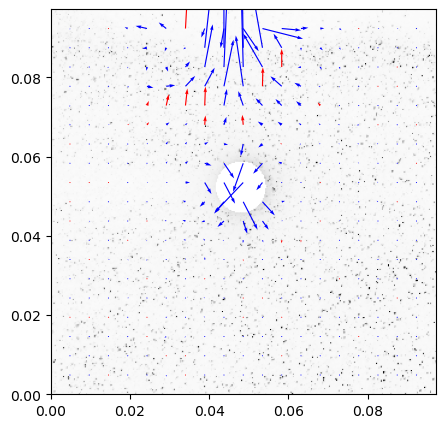

0.4


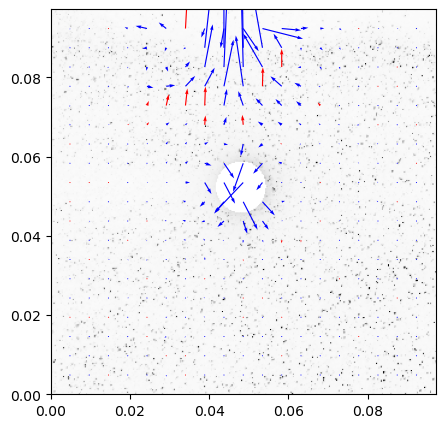

0.5


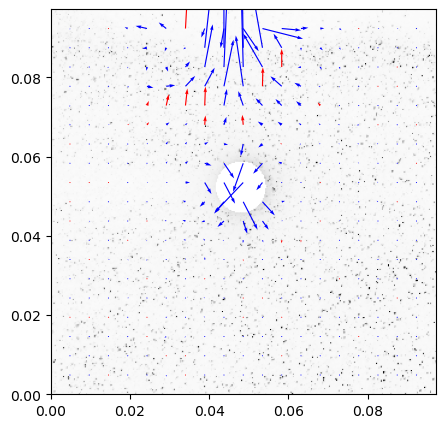

0.6


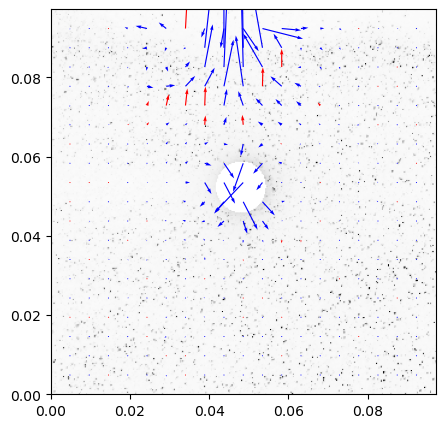

0.7000000000000001


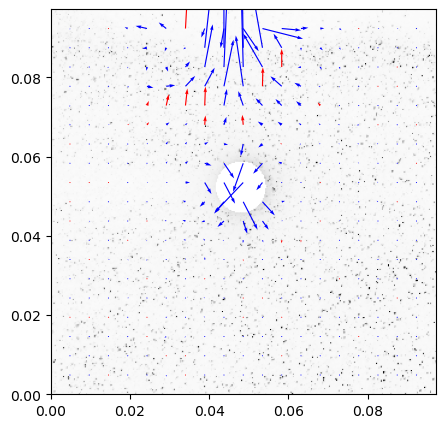

0.8


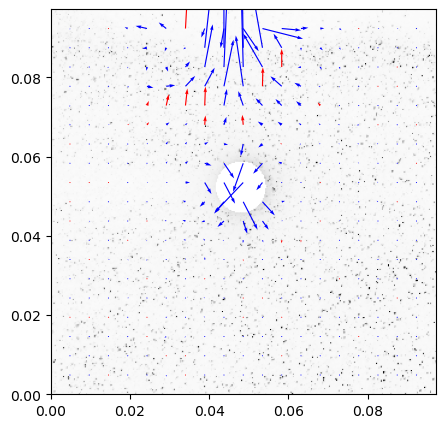

0.9


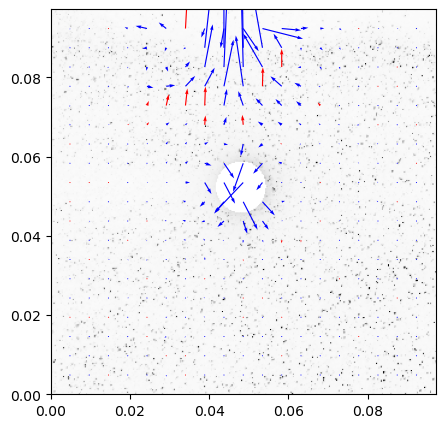

1.0


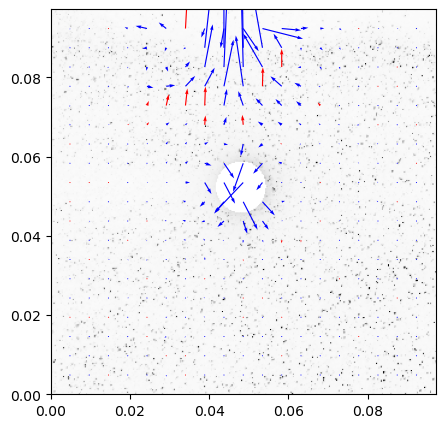

1.1


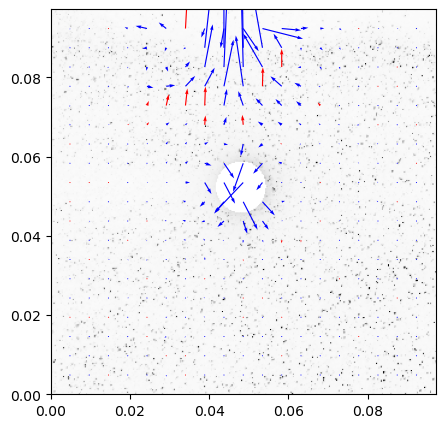

1.2000000000000002


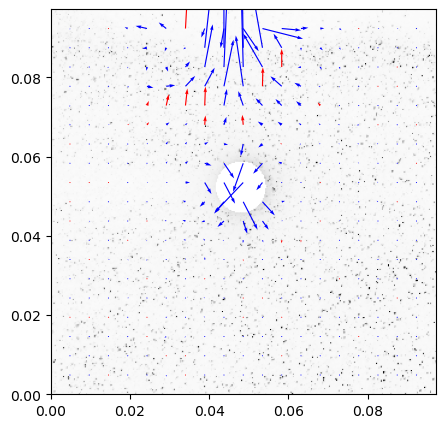

1.3000000000000003


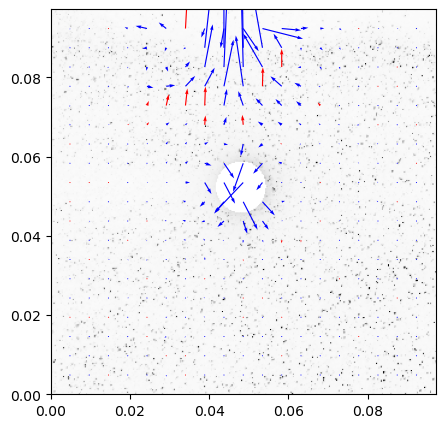

In [ ]:
for threshold in thresholds:    
# process again with the masked images, for comparison# process once with the original images
    u, v, sig2noise = pyprocess.extended_search_area_piv(
                                                        masked_a.astype(np.int32) , masked_b.astype(np.int32), 
                                                        window_size = window_size,
                                                        overlap = overlap, 
                                                        dt= dt, 
                                                        search_area_size = search_area_size, 
                                                        sig2noise_method = 'peak2peak')
    x, y = pyprocess.get_coordinates( image_size = masked_a.shape, search_area_size = search_area_size, overlap = overlap )
    flags_g = validation.global_val( u, v, (-300.,300.),(-300.,300.))
    flags_s2n = validation.sig2noise_val( sig2noise, threshold = 1.1)
    flags = flags_g | flags_s2n
    u, v = filters.replace_outliers( u, v, flags, method='localmean', max_iter = 3, kernel_size = 3)

    # FOR SI use scaling factor to get new coordinates
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = scaling_factor) # [m/s] and [m]
    x, y, u, v = tools.transform_coordinates(x, y, u, v)

    # save to a file
    tools.save(os.path.join(save_folder,'test_two_pic_only_masked.txt'), x, y, u, v, flags,
                None, fmt='%9.6f', delimiter='\t')

    fig, ax = plt.subplots(figsize=(5,5))
    # ax.imshow(masked_b)
    print(threshold)
    tools.display_vector_field(os.path.join(save_folder,'test_two_pic_only_masked.txt'), ax=ax,
                                scaling_factor = scaling_factor, scale = scale, width = width, on_img=True,
                            image_name =  os.path.join(save_folder, 'cut_image', 'cut_part.tif'))

## Sphere's location is an interpolation between the 2 images

In [ ]:
first_coor, diameter1 = Mf.select_circle(im_a_path, 'img_a - Select circle')
sec_coor, diameter2 = Mf.select_circle(im_b_path, 'img_b - Select circle')
diameter = (diameter2+diameter1)/2

# only int is valid (location is a pixel.)
sphere_coordinate = [int((g + h) / 2) for g, h in zip(first_coor, sec_coor)]
sphere_coordinate

file_path = os.path.join(save_folder, 'sphere_location.pkl')

# Save the list to the specified location using pickle
with open(file_path, 'wb') as file:
    pickle.dump(sphere_coordinate, file)

AttributeError: module 'My_functions' has no attribute 'select_circle'

In [ ]:
u1 = np.ma.getdata(u)

In [ ]:
dudy = np.diff(u1)/np.diff(y)
print (dudy)

[[ inf  inf -inf -inf -inf -inf  inf  inf]
 [ inf  inf -inf -inf -inf  inf  inf  inf]
 [ inf  inf  inf -inf -inf  inf  inf -inf]
 [-inf  inf  inf -inf -inf  inf  inf  inf]
 [-inf -inf  inf  inf  inf -inf -inf -inf]
 [-inf  inf -inf  inf  inf -inf -inf  inf]
 [-inf -inf  inf  inf  inf -inf -inf -inf]
 [ inf -inf  inf  inf  inf  inf  inf  inf]
 [-inf  inf  inf -inf  inf  inf  inf  inf]
 [-inf  inf  inf -inf  inf  inf  inf -inf]]


### Caculating drag force due to viscous forces

<img title="simple" alt="Alt text" src="../Picture/IMG for markdown/simple.png">

<img title="simple" alt="Alt text" src="../Picture/IMG for markdown/drag.png">

For two dimentional only! $\mathcal{D} [\frac{N}{m}]$ page 517 assume axxisymetric and ...

$ \mathcal{D} = \int_0^{2\pi} \tau_{wall} sin(\theta) Rd\theta = 2R\int_0^{\pi} \tau_{wall} sin(\theta) d\theta = 2R\int_0^{\pi} \mu(\frac{du}{dy} + \frac{dv}{dx}) sin(\theta) d\theta $